In [2]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras import layers
from tensorflow.keras import losses
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import tensorflow as tf

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
recipes_df = pd.read_csv('labeled_recipes.csv')
recipes_df.head()

,title,ingredients,instructions,label
0,Best Meatloaf,2 pounds ground beef\n¼ cup bread crumbs (1 sl...,Preheat oven to 375°F (175°C).\nCombine ketchu...,regular
1,Chicken Lo Mein,1 pound chicken breasts\n8 ounces dry lo mein ...,"In a small bowl, whisk together sauce ingredie...",regular
2,Easy Homemade Mac and Cheese,8 ounces elbow macaroni uncooked\nCheese Sauce...,Cook elbow macaroni according to package instr...,regular
3,Chocolate Cake,1 ¼ cups all-purpose flour\n1 ¼ cups granulate...,Preheat oven to 350 degrees F.\nLine two 6” ro...,regular
4,Crock Pot Teriyaki Chicken,2 pounds chicken breasts\n½ cup honey\n¾ cup s...,Grease the container of a large slow cooker.\n...,regular


In [4]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

recipes_df['ingredients'] = recipes_df['ingredients'].apply(clean_text)
recipes_df['instructions'] = recipes_df['instructions'].apply(clean_text)

recipes_df['text'] = recipes_df['ingredients'] + ' ' + recipes_df['instructions']
recipes_df['label'] = recipes_df['label'].map({'regular': 0, 'fitness': 1})
recipes_df.drop(columns=['ingredients'], inplace=True)
recipes_df.drop(columns=['instructions'], inplace=True)

In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(recipes_df['text'], recipes_df['label'], test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [6]:
def df_to_tf_examples(X, y):
    for text, label in zip(X, y):
        yield {'text': tf.convert_to_tensor(text, dtype=tf.string),
               'label': tf.convert_to_tensor(label, dtype=tf.int64)}

train_dataset = tf.data.Dataset.from_generator(
    lambda: df_to_tf_examples(X_train, y_train),
    output_signature={'text': tf.TensorSpec(shape=(), dtype=tf.string), 'label': tf.TensorSpec(shape=(), dtype=tf.int64)}
)

valid_dataset = tf.data.Dataset.from_generator(
    lambda: df_to_tf_examples(X_valid, y_valid),
    output_signature={'text': tf.TensorSpec(shape=(), dtype=tf.string), 'label': tf.TensorSpec(shape=(), dtype=tf.int64)}
)

test_dataset = tf.data.Dataset.from_generator(
    lambda: df_to_tf_examples(X_test, y_test),
    output_signature={'text': tf.TensorSpec(shape=(), dtype=tf.string), 'label': tf.TensorSpec(shape=(), dtype=tf.int64)}
)

In [7]:
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=500, seed=42).batch(batch_size)
valid_dataset = valid_dataset.shuffle(buffer_size=500, seed=42).batch(batch_size)
test_dataset = test_dataset.shuffle(buffer_size=500, seed=42).batch(batch_size)

In [8]:
def custom_standardization(input_text):
    input_text = tf.strings.regex_replace(input_text, '[^a-zA-Z0-9 ]', '')
    return tf.strings.lower(input_text)

max_features = 10000 

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='tf_idf',
    ngrams=(1, 2)
)


In [9]:
train_text = train_dataset.map(lambda x: x['text'])
train_labels = train_dataset.map(lambda x: x['label'])

vectorize_layer.adapt(train_text)

train_text_vectorized = train_text.map(lambda x: vectorize_layer(x))
train_dataset_vectorized = tf.data.Dataset.zip((train_text_vectorized, train_labels))

for example in train_dataset_vectorized.take(2):
    text, label = example
    print(f"Vectorized Text: {text.numpy()}")
    print(f"Label: {label.numpy()}")

Vectorized Text: [[0.        9.010914  2.2048328 ... 0.        0.        0.       ]
 [0.        1.3862944 1.4698886 ... 0.        0.        0.       ]
 [0.        0.6931472 0.        ... 0.        0.        0.       ]
 ...
 [0.        4.158883  2.9397771 ... 0.        0.        0.       ]
 [0.        3.465736  8.084387  ... 0.        0.        0.       ]
 [0.        2.0794415 2.2048328 ... 0.        0.        0.       ]]
Label: [1 1 1 1 1 1 0 1 1 0 0 0 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 0 1 1 0 1]
Vectorized Text: [[ 0.         3.465736   6.6144986 ...  0.         0.         0.       ]
 [ 0.         4.158883   1.4698886 ...  0.         0.         0.       ]
 [ 0.         7.624619  14.698886  ...  0.         0.         0.       ]
 ...
 [ 0.        12.476649   6.6144986 ...  0.         0.         0.       ]
 [ 0.         8.317766   2.9397771 ...  0.         0.         0.       ]
 [ 0.         2.7725887  1.4698886 ...  0.         0.         0.       ]]
Label: [1 0 1 0 1 0 0 0 1 1 0 0 1 1 1 0 0

2024-11-28 19:40:49.290169: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-28 19:40:49.400661: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
valid_text = valid_dataset.map(lambda x: x['text'])
valid_labels = valid_dataset.map(lambda x: x['label'])

test_text = test_dataset.map(lambda x: x['text'])
test_labels = test_dataset.map(lambda x: x['label'])

valid_text_vectorized = valid_text.map(lambda x: vectorize_layer(x))
test_text_vectorized = test_text.map(lambda x: vectorize_layer(x))

valid_dataset_vectorized = tf.data.Dataset.zip((valid_text_vectorized, valid_labels))
test_dataset_vectorized = tf.data.Dataset.zip((test_text_vectorized, test_labels))

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset_vectorized = train_dataset_vectorized.cache().prefetch(buffer_size=AUTOTUNE)
valid_dataset_vectorized = valid_dataset_vectorized.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset_vectorized = test_dataset_vectorized.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
for example in train_dataset_vectorized.take(2):
    text, label = example
    print(f"Vectorized Text: {text.numpy()}")
    print(f"Label: {label.numpy()}")

Vectorized Text: [[ 0.         7.624619   8.819331  ...  0.         0.         0.       ]
 [ 0.         8.317766  11.024164  ...  0.         0.         0.       ]
 [ 0.         6.2383246  0.        ...  0.         0.         0.       ]
 ...
 [ 0.         5.5451775  9.5542755 ...  0.         0.         0.       ]
 [ 0.         6.2383246  3.6747215 ...  0.         0.         0.       ]
 [ 0.         9.010914  10.28922   ...  0.         0.         0.       ]]
Label: [1 1 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 0 0 1 1 0 0 1 1 1 0 1 1 0 0]
Vectorized Text: [[ 0.         4.8520303 11.759109  ...  0.         0.         0.       ]
 [ 0.         4.8520303  5.8795543 ...  0.         0.         0.       ]
 [ 0.         6.2383246  5.8795543 ...  0.         0.         0.       ]
 ...
 [ 0.         4.8520303  5.14461   ...  0.         0.         0.       ]
 [ 0.         4.158883   5.8795543 ...  0.         0.         0.       ]
 [ 0.        11.090355   0.7349443 ...  0.         0.         0.       ]]
Label

2024-11-28 19:40:54.522683: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [13]:
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(8660,)), 
    layers.Dense(10, activation='relu'), 
    layers.Dense(2, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

history = model.fit(
    train_dataset_vectorized, 
    validation_data=valid_dataset_vectorized, 
    epochs=50
)

test_loss, test_acc = model.evaluate(test_dataset_vectorized)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")



Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5414 - loss: 0.7310 - val_accuracy: 0.4545 - val_loss: 0.6453
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9429 - loss: 0.3977 - val_accuracy: 0.3636 - val_loss: 0.7607
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9753 - loss: 0.2831 - val_accuracy: 0.3636 - val_loss: 0.8771
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.1913 - val_accuracy: 0.3636 - val_loss: 1.0551
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.1265 - val_accuracy: 0.3636 - val_loss: 1.2596
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0851 - val_accuracy: 0.3636 - val_loss: 1.4417
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0598 - val_accuracy: 0.2727 - val_loss: 1.5968
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0422 - val_accuracy: 0.1818 - val_loss: 1.7227
Epoch 9/50
3/3 ━━━

2024-11-28 19:40:56.705399: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-11-28 19:40:56.817502: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-28 19:40:56.855196: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0100 - val_accuracy: 0.4545 - val_loss: 2.0564
Epoch 14/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0081 - val_accuracy: 0.4545 - val_loss: 2.0952
Epoch 15/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0067 - val_accuracy: 0.4545 - val_loss: 2.1217
Epoch 16/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0056 - val_accuracy: 0.3636 - val_loss: 2.1429
Epoch 17/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0048 - val_accuracy: 0.3636 - val_loss: 2.1612
Epoch 18/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 0.3636 - val_loss: 2.1776
Epoch 19/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.3636 - val_loss: 2.1927
Epoch 20/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.3636 - val_loss: 2.2065
Epoch 21/50


2024-11-28 19:40:56.937145: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.3636 - val_loss: 2.2677
Epoch 27/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.3636 - val_loss: 2.2752
Epoch 28/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.3636 - val_loss: 2.2815
Epoch 29/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.3636 - val_loss: 2.2868
Epoch 30/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.3636 - val_loss: 2.2913
Epoch 31/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.3636 - val_loss: 2.2950
Epoch 32/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.3636 - val_loss: 2.2981
Epoch 33/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.3636 - val_loss: 2.3045
Epoch 34/50


2024-11-28 19:40:57.188498: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.1154e-04 - val_accuracy: 0.3636 - val_loss: 2.4059
Epoch 44/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.8872e-04 - val_accuracy: 0.3636 - val_loss: 2.4130
Epoch 45/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.6718e-04 - val_accuracy: 0.3636 - val_loss: 2.4194
Epoch 46/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.4584e-04 - val_accuracy: 0.3636 - val_loss: 2.4251
Epoch 47/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.2547e-04 - val_accuracy: 0.3636 - val_loss: 2.4303
Epoch 48/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.0631e-04 - val_accuracy: 0.3636 - val_loss: 2.4350
Epoch 49/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.8799e-04 - val_accuracy: 0.3636 - val_loss: 2.4393
Epoch 50/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.7078e-04 - val_accuracy: 0.3636

In [14]:
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(8660,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

history = model.fit(
    train_dataset_vectorized, 
    validation_data=valid_dataset_vectorized, 
    epochs=50
)

test_loss, test_acc = model.evaluate(test_dataset_vectorized)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5275 - loss: 0.8675 - val_accuracy: 0.6364 - val_loss: 0.9084
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9944 - loss: 0.0983 - val_accuracy: 0.4545 - val_loss: 1.5652
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0358 - val_accuracy: 0.2727 - val_loss: 2.2824
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0157 - val_accuracy: 0.2727 - val_loss: 2.8604
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0077 - val_accuracy: 0.2727 - val_loss: 3.2866
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0042 - val_accuracy: 0.2727 - val_loss: 3.6111
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.2727 - val_loss: 3.8639
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.2727 - val_loss: 4.0577
Epoch 9

2024-11-28 19:41:03.750805: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4338e-04 - val_accuracy: 0.2727 - val_loss: 4.6639
Epoch 23/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3579e-04 - val_accuracy: 0.2727 - val_loss: 4.6663
Epoch 24/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2886e-04 - val_accuracy: 0.2727 - val_loss: 4.6676
Epoch 25/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2239e-04 - val_accuracy: 0.2727 - val_loss: 4.6682
Epoch 26/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1662e-04 - val_accuracy: 0.2727 - val_loss: 4.6684
Epoch 27/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1136e-04 - val_accuracy: 0.2727 - val_loss: 4.6683
Epoch 28/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0660e-04 - val_accuracy: 0.2727 - val_loss: 4.6682
Epoch 29/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0215e-04 - val_accuracy: 0.2727

In [15]:
from tensorflow.keras.layers import LeakyReLU
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(8660,)),
    layers.Dense(128),
    LeakyReLU(alpha=0.3),
    layers.Dense(64),
    LeakyReLU(alpha=0.3),
    layers.Dense(2, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

history = model.fit(
    train_dataset_vectorized, 
    validation_data=valid_dataset_vectorized, 
    epochs=50
)

test_loss, test_acc = model.evaluate(test_dataset_vectorized)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5504 - loss: 0.7810 - val_accuracy: 0.2727 - val_loss: 1.4822
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0293 - val_accuracy: 0.3636 - val_loss: 2.0826
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0090 - val_accuracy: 0.3636 - val_loss: 2.5250
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.3636 - val_loss: 2.8649
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.3636 - val_loss: 3.1252
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.9074e-04 - val_accuracy: 0.2727 - val_loss: 3.3307
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.3837e-04 - val_accuracy: 0.2727 - val_loss: 3.4948
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.6961e-04 - val_accuracy: 0.2727 - val_loss: 3.6226
Epoch 

2024-11-28 19:41:09.045825: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.8693e-05 - val_accuracy: 0.3636 - val_loss: 4.0823
Epoch 38/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.8188e-05 - val_accuracy: 0.3636 - val_loss: 4.0840
Epoch 39/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7692e-05 - val_accuracy: 0.3636 - val_loss: 4.0857
Epoch 40/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7202e-05 - val_accuracy: 0.3636 - val_loss: 4.0874
Epoch 41/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.6730e-05 - val_accuracy: 0.3636 - val_loss: 4.0890
Epoch 42/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6268e-05 - val_accuracy: 0.3636 - val_loss: 4.0907
Epoch 43/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.5811e-05 - val_accuracy: 0.3636 - val_loss: 4.0924
Epoch 44/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.5370e-05 - val_accuracy: 0.3636

In [17]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0005)

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy'])

history = model.fit(
    train_dataset_vectorized, 
    validation_data=valid_dataset_vectorized, 
    epochs=50
)

test_loss, test_acc = model.evaluate(test_dataset_vectorized)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 0.4545 - val_loss: 5.9335
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 0.4545 - val_loss: 5.9340
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 0.4545 - val_loss: 5.9346
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 0.4545 - val_loss: 5.9354
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 0.4545 - val_loss: 5.9363
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 0.4545 - val_loss: 5.9372
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 0.4545 - val_loss: 5.9383
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 0

2024-11-28 19:41:20.257532: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [25]:
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(8660,)),
    layers.Dense(128),
    layers.Dropout(0.5),
    layers.Dense(64),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

history = model.fit(
    train_dataset_vectorized, 
    validation_data=valid_dataset_vectorized, 
    epochs=50
)

test_loss, test_acc = model.evaluate(test_dataset_vectorized)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5548 - loss: 1.6132 - val_accuracy: 0.2727 - val_loss: 1.8698
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8706 - loss: 0.3071 - val_accuracy: 0.3636 - val_loss: 3.0140
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9350 - loss: 0.2831 - val_accuracy: 0.3636 - val_loss: 3.6059
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9905 - loss: 0.0336 - val_accuracy: 0.2727 - val_loss: 4.2365
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9944 - loss: 0.0215 - val_accuracy: 0.3636 - val_loss: 4.7070
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9849 - loss: 0.0179 - val_accuracy: 0.3636 - val_loss: 4.9128
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9597 - loss: 0.4349 - val_accuracy: 0.4545 - val_loss: 5.0393
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.4545 - val_loss: 5.2117
Epoch 

In [72]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(8660,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(
    train_dataset_vectorized,
    validation_data=valid_dataset_vectorized,
    epochs=50,
    callbacks=[early_stopping]
)

test_loss, test_acc = model.evaluate(test_dataset_vectorized)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5258 - loss: 1.1407 - val_accuracy: 0.6364 - val_loss: 0.7596
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6310 - loss: 0.6780 - val_accuracy: 0.3636 - val_loss: 1.2183
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8186 - loss: 0.5285 - val_accuracy: 0.2727 - val_loss: 1.6819
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7761 - loss: 0.4649 - val_accuracy: 0.2727 - val_loss: 2.1565
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8276 - loss: 0.4326 - val_accuracy: 0.2727 - val_loss: 2.3737
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8618 - loss: 0.7090 - val_accuracy: 0.1818 - val_loss: 2.5057
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7500 - loss: 0.8807
Test accuracy: 0.75, Test loss: 0.8806567192077637


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Accuracy: 0.7500
Precision: 0.8500
Recall: 0.7000
F1 Score: 0.6975


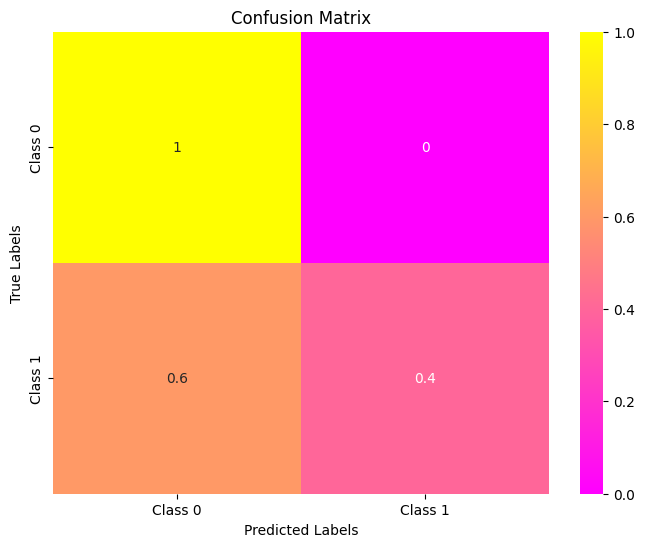

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_true = []
y_pred = []

for texts, labels in test_dataset_vectorized:
    predictions = model.predict(texts)  
    y_true.extend(labels.numpy())       
    y_pred.extend(np.argmax(predictions, axis=1)) 

y_true = np.array(y_true)
y_pred = np.array(y_pred)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


class_names = ['Class 0', 'Class 1']

cm = confusion_matrix(y_true, y_pred, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="spring", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()




In [89]:
from sklearn.metrics import classification_report
import numpy as np

true_labels = []
predictions = []

for texts, labels in test_dataset_vectorized: 

    preds = model.predict(texts)
    true_labels.extend(labels.numpy())
    predictions.extend(np.argmax(preds, axis=1))


true_labels = np.array(true_labels)
predictions = np.array(predictions)

print("\nClassification Report on Test Set:")
print(classification_report(true_labels, predictions, target_names=["regular", "fitness"]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Classification Report on Test Set:
              precision    recall  f1-score   support

     regular       0.70      1.00      0.82         7
     fitness       1.00      0.40      0.57         5

    accuracy                           0.75        12
   macro avg       0.85      0.70      0.70        12
weighted avg       0.82      0.75      0.72        12



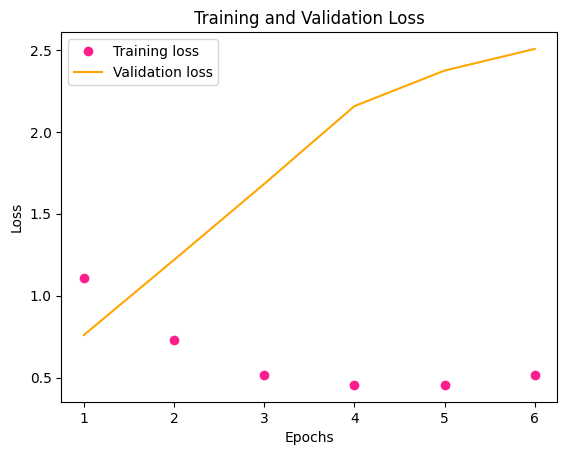

In [75]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']


epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'o', color='#ff1d8e', label='Training loss')
plt.plot(epochs, val_loss, color='#ffa600', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


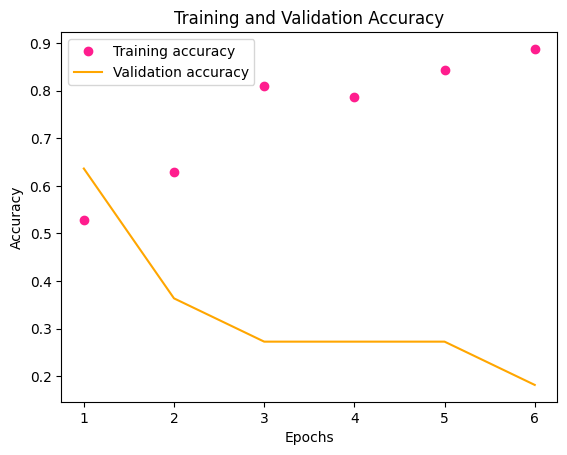

In [76]:
plt.plot(epochs, acc, 'o', color='#ff1d8e', label='Training accuracy')
plt.plot(epochs, val_acc, color='#ffa600', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [97]:
dataset_recipe1='''1 ¼ cups all-purpose flour 1 ¼ cups granulated sugar ¼ cup unsweetened cocoa powder 
½ teaspoon baking soda ½ teaspoon baking powder ½ teaspoon sea salt ½ teaspoon espresso powder 
½ cup canola oil (or melted butter) 2 eggs, large ½ cup sour cream ½ cup whole milk 
1 teaspoon pure vanilla extract ½ cup mini chocolate chips
Preheat oven to 350 degrees F.
Line two 6” round cake pans with parchment paper and grease well. Set aside.
In a medium bowl, combine flour, sugar, cocoa powder, baking soda, baking powder, sea salt and espresso powder. Set aside
In a large bowl, whisk together canola oil, eggs, sour cream, milk and vanilla until the mixture is smooth.
Add dry ingredients to the wet ingredients and stir until combined.
Add mini chocolate chips and stir until evenly distributed.
Divide the batter evenly into the two prepared cake pans.
Bake in the preheated oven for 30-35 minutes, or until a toothpick inserted in the center of the cakes comes out clean or with a few crumbs.
Place cake pans on a wire cooling rack to cool to room temperature (takes about 30 minutes).
Once cool, lift cakes out of the pans and remove parchment paper. Let cool completely on the wire cooling rack.
Once cool, with chocolate frosting and serve.'''


cleaned_recipe = clean_text(dataset_recipe1)
recipe_vectorized = vectorize_layer(tf.constant([cleaned_recipe]))
recipe_vectorized = tf.reshape(recipe_vectorized, (1, -1))
prediction = model.predict(recipe_vectorized)
predicted_class_index = np.argmax(prediction)
class_labels = ['Regular', 'Fitness']
predicted_class_label = class_labels[predicted_class_index]
print(f"Predicted class: {predicted_class_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predicted class: Fitness


In [94]:
dataset_recipe2='''3-4 overripe bananas (1 ½ cups mashed)
½ cup salted butter melted
2 eggs beaten
2 teaspoons pure vanilla extract
¾ cup granulated sugar
¼ cup light brown sugar
1 ½ cups all-purpose flour
1 teaspoon baking soda
½ teaspoon baking powder
½ teaspoon fine sea salt
½ teaspoon cinnamon'''

cleaned_recipe = clean_text(dataset_recipe2)
recipe_vectorized = vectorize_layer(tf.constant([cleaned_recipe]))
recipe_vectorized = tf.reshape(recipe_vectorized, (1, -1))
prediction = model.predict(recipe_vectorized)
predicted_class_index = np.argmax(prediction)
class_labels = ['Regular', 'Fitness']
predicted_class_label = class_labels[predicted_class_index]
print(f"Predicted class: {predicted_class_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Predicted class: Fitness


In [80]:
dataset_recipe3='''4 cups water
2 cups uncooked white rice
3 tablespoons soy sauce
2 tablespoons creamy peanut butter
2 teaspoons white wine vinegar
¼ teaspoon cayenne pepper
3 tablespoons olive oil
4 skinless, boneless chicken breast halves - cut into thin strips
3 tablespoons chopped garlic
1 ½ tablespoons chopped fresh ginger root
2 ½ cups broccoli florets
¾ cup chopped green onions
⅓ cup unsalted dry-roasted peanuts
Combine water and rice in a saucepan over medium-high heat; bring to a boil. Reduce heat to low, cover, and simmer until rice is tender and liquid is absorbed, about 20 minutes.
Meanwhile, stir together soy sauce, peanut butter, vinegar, and cayenne pepper in a small bowl; set aside.
Heat olive oil in a skillet or wok over high heat. Cook and stir chicken, garlic, and ginger in hot oil until chicken is lightly browned, about 5 minutes. Reduce heat to medium and add broccoli, green onions, peanuts, and soy sauce mixture. Cook, stirring frequently, until broccoli is tender and chicken is cooked through, about 5 minutes.
Serve chicken-broccoli mixture over cooked rice.'''

cleaned_recipe = clean_text(dataset_recipe3)
recipe_vectorized = vectorize_layer(tf.constant([cleaned_recipe]))
recipe_vectorized = tf.reshape(recipe_vectorized, (1, -1))
prediction = model.predict(recipe_vectorized)
predicted_class_index = np.argmax(prediction)
class_labels = ['Regular', 'Fitness']
predicted_class_label = class_labels[predicted_class_index]
print(f"Predicted class: {predicted_class_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Predicted class: Regular


In [95]:
dataset_recipe4='''40g Oats
30g Vanilla Whey protein
5g cacao powder
50g banana
15g Hershey Zero Sugar
Chocolate Baking Chips'''

cleaned_recipe = clean_text(dataset_recipe4)
recipe_vectorized = vectorize_layer(tf.constant([cleaned_recipe]))
recipe_vectorized = tf.reshape(recipe_vectorized, (1, -1))
prediction = model.predict(recipe_vectorized)
predicted_class_index = np.argmax(prediction)
class_labels = ['Regular', 'Fitness']
predicted_class_label = class_labels[predicted_class_index]
print(f"Predicted class: {predicted_class_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted class: Regular


In [82]:
recipe_text_example1 = '''1 (4 pound) chicken, cut into pieces
1 cup buttermilk
2 cups all-purpose flour for coating
1 teaspoon paprika
salt and pepper to taste
2 quarts vegetable oil for frying
Take your cut up chicken pieces and skin them if you prefer.
Put the flour in a large plastic bag (let the amount of chicken you are cooking dictate the amount of flour you use).
Season the flour with paprika, salt and pepper to taste (paprika helps to brown the chicken).
Dip chicken pieces in buttermilk then, a few at a time, put them in the bag with the flour,
seal the bag and shake to coat well.
Place the coated chicken on a cookie sheet or tray, and cover with a clean dish towel or waxed paper. 
Fill a large skillet (cast iron is best) about 1/3 to 1/2 full with vegetable oil. Heat until VERY hot.
Put in as many chicken pieces as the skillet can hold. Brown the chicken in HOT oil on both sides.
When browned, reduce heat and cover skillet; let cook for 30 minutes (the chicken will be cooked through but not crispy). 
Remove cover, raise heat again, and continue to fry until crispy.
Drain the fried chicken on paper towels. Depending on how much chicken you have, you may have to fry in a few shifts.
Keep the finished chicken in a slightly warm oven while preparing the rest.
'''

cleaned_recipe = clean_text(recipe_text_example1)
recipe_vectorized = vectorize_layer(tf.constant([cleaned_recipe]))
recipe_vectorized = tf.reshape(recipe_vectorized, (1, -1))
prediction = model.predict(recipe_vectorized)
predicted_class_index = np.argmax(prediction)
class_labels = ['Regular', 'Fitness']
predicted_class_label = class_labels[predicted_class_index]
print(f"Predicted class: {predicted_class_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Predicted class: Regular


In [83]:
recipe_text_example2 = "For a hearty spaghetti bolognese, start by heating olive oil in a large pan over medium heat. Add 1 diced onion, 2 minced garlic cloves, and 1 grated carrot, cooking until softened. Add 500g ground beef, cooking until browned. Stir in 1 can of crushed tomatoes, 2 tablespoons tomato paste, 1 teaspoon dried oregano, and 1 teaspoon dried basil. Simmer for 20 minutes, seasoning with salt and pepper to taste. Serve over cooked spaghetti, garnished with grated Parmesan and fresh parsley."

cleaned_recipe = clean_text(recipe_text_example2)
recipe_vectorized = vectorize_layer(tf.constant([cleaned_recipe]))
recipe_vectorized = tf.reshape(recipe_vectorized, (1, -1))
prediction = model.predict(recipe_vectorized)
predicted_class_index = np.argmax(prediction)
class_labels = ['Regular', 'Fitness']
predicted_class_label = class_labels[predicted_class_index]
print(f"Predicted class: {predicted_class_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Predicted class: Regular


In [84]:
recipe_text_example3 = "For a grilled salmon and quinoa bowl, marinate 2 salmon fillets in a mixture of 2 tablespoons olive oil, 1 tablespoon lemon juice, 1 minced garlic clove, and a pinch of salt and pepper. Grill the salmon over medium heat for 4-5 minutes per side. Cook 1 cup quinoa according to package instructions and let cool. Assemble the bowl with quinoa, a handful of baby spinach, ½ avocado sliced, cherry tomatoes, and cucumber slices. Top with grilled salmon and drizzle with a light lemon-tahini dressing."

cleaned_recipe = clean_text(recipe_text_example3)
recipe_vectorized = vectorize_layer(tf.constant([cleaned_recipe]))
recipe_vectorized = tf.reshape(recipe_vectorized, (1, -1))
prediction = model.predict(recipe_vectorized)
predicted_class_index = np.argmax(prediction)
class_labels = ['Regular', 'Fitness']
predicted_class_label = class_labels[predicted_class_index]
print(f"Predicted class: {predicted_class_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Predicted class: Regular


In [85]:
recipe_text_example4 = '''1 scoop of whey protein powder vanilla flavor
1/2 cup oats
1/4 cup unsweetened almond milk
1 large egg
1/2 teaspoon baking powder
1/4 teaspoon vanilla extract
Pinch of salt
1 teaspoon honey or maple syrup (optional)
fresh berries, peanut butter, or almond butter
In a bowl, mix together the whey protein powder, oat flour, baking powder, salt, and vanilla extract.
In a separate bowl, whisk the egg and almond milk.
Add the wet ingredients to the dry ingredients and mix until smooth. If the batter is too thick, add a bit more milk to adjust.
Heat a non-stick skillet over medium heat. Lightly grease with cooking spray or coconut oil.
Pour the batter into the skillet to form small pancakes and cook for 2-3 minutes on each side or until golden brown.
Serve with fresh berries, a drizzle of honey or syrup, and a spoonful of peanut butter for extra protein.

'''

cleaned_recipe = clean_text(recipe_text_example4)
recipe_vectorized = vectorize_layer(tf.constant([cleaned_recipe]))
recipe_vectorized = tf.reshape(recipe_vectorized, (1, -1))
prediction = model.predict(recipe_vectorized)
predicted_class_index = np.argmax(prediction)
class_labels = ['Regular', 'Fitness']
predicted_class_label = class_labels[predicted_class_index]
print(f"Predicted class: {predicted_class_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Predicted class: Regular


In [90]:
from tensorflow.keras import regularizers

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(8660,)),
    layers.Dense(128, activation='relu', 
                 kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu', 
                 kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(
    train_dataset_vectorized,
    validation_data=valid_dataset_vectorized,
    epochs=50,
    callbacks=[early_stopping]
)

test_loss, test_acc = model.evaluate(test_dataset_vectorized)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6730 - loss: 4.0019 - val_accuracy: 0.2727 - val_loss: 4.0734
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6886 - loss: 3.4209 - val_accuracy: 0.3636 - val_loss: 3.5245
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8527 - loss: 2.7279 - val_accuracy: 0.4545 - val_loss: 3.1646
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8965 - loss: 2.4353 - val_accuracy: 0.5455 - val_loss: 3.0151
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8943 - loss: 2.2019 - val_accuracy: 0.4545 - val_loss: 3.1308
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9524 - loss: 2.2050 - val_accuracy: 0.4545 - val_loss: 3.3356
Epoch 7/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8438 - loss: 2.1391

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8679 - loss: 2.0735 - val_accuracy: 0.4545 - val_loss: 3.5161
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9585 - loss: 1.8297 - val_accuracy: 0.3636 - val_loss: 3.9859
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9619 - loss: 1.7237 - val_accuracy: 0.2727 - val_loss: 4.5577
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7500 - loss: 2.9356
Test accuracy: 0.75, Test loss: 2.935645341873169


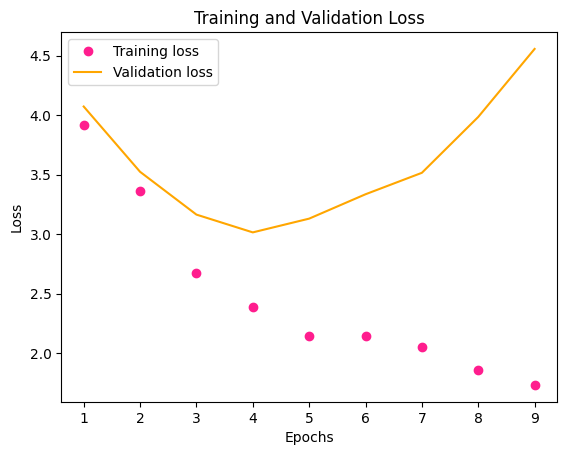

In [91]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']


epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'o', color='#ff1d8e', label='Training loss')
plt.plot(epochs, val_loss, color='#ffa600', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

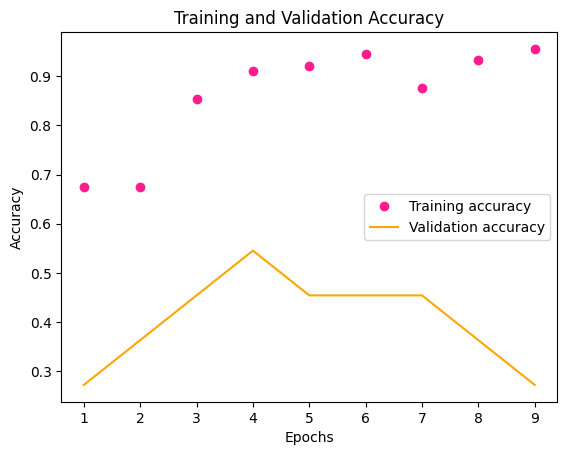

In [92]:
plt.plot(epochs, acc, 'o', color='#ff1d8e', label='Training accuracy')
plt.plot(epochs, val_acc, color='#ffa600', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Accuracy: 0.7500
Precision: 0.7500
Recall: 0.7286
F1 Score: 0.7333


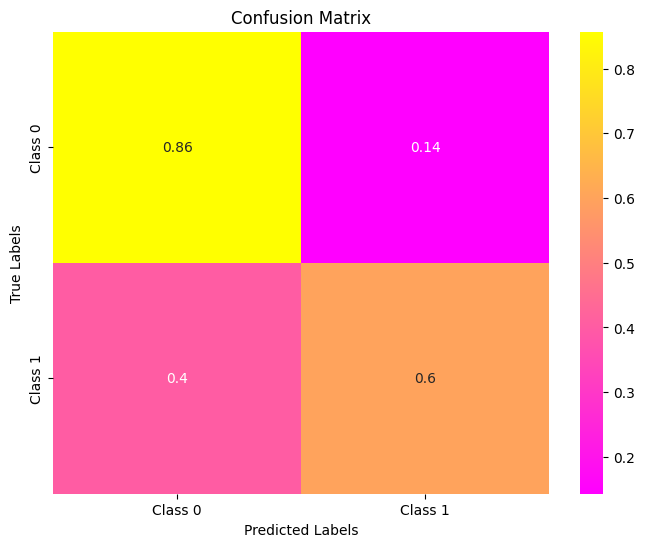

In [93]:
y_true = []
y_pred = []

for texts, labels in test_dataset_vectorized:
    predictions = model.predict(texts)  
    y_true.extend(labels.numpy())       
    y_pred.extend(np.argmax(predictions, axis=1)) 

y_true = np.array(y_true)
y_pred = np.array(y_pred)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


class_names = ['Class 0', 'Class 1']

cm = confusion_matrix(y_true, y_pred, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="spring", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()